# Analysis of COVID-19 in the United States

This notebook uses data from several sources to analyze the relationship between several social, economic, and demographic factors and the role these play in the shaping of the COVID-19 pandemic in the United States.

Author: Aditya Ranjan

<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.

## 1. Data Preparation
My first step is to comb through all of the source files, clean them, and then extract the information I want for each of the 2959 counties. Then, I will store all of the combined information in one clean data frame for future use. After all of this is done, I can finally move on to analyzing the data.

### A. Libraries
Apart from standard data science libraries such as numpy, pandas, and matplotlib, I use one of plotly's geospatial tools to plot the distribution of a certain characteristic on a United States Counties map. This helps
visualize the spatial distribution of a certain factor, which can be correlated with other factors for discovering interesting patterns.

In [1]:
#Import Essential Libraries
import numpy as np
from numpy import *
import pandas as pd
import matplotlib.pyplot as plt
import plotly.figure_factory as ff

### B. Functions
Below is a list of some functions I wrote that are called repeatedly throughout the notebook and make certain processes much easier to implement.

In [2]:
#Cleaning routine for files from USDA Economic Research Service
def cleanGovData(file, index):
    data = pd.read_csv(file)
    data.columns = data.iloc[index]
    data = data.drop([i for i in range(index + 1)], axis = 0)
    data.index -= index + 1
    data = data.rename(columns = {"FIPStxt" : "FIPS"})
    data["FIPS"] = list(map(int, data["FIPS"]))
    return data


#Creates a chloropleth map on a USA counties map template from any list
def plotMap(inputList):
    endPoints = list(np.percentile(inputList, [5 + (5 * i) for i in range(19)])) #5% intervals for range of numbers and colors
    i = 0
    while i < len(endPoints):
        if endPoints.count(endPoints[i]) > 1 or endPoints[i] == min(inputList) or endPoints[i] == max(inputList):
            del endPoints[i] #removes any repeating intervals or minimum/maximum for well balanced intervals
        else:
            i += 1
            
    colorScale, numColors = [], len(endPoints) + 1
    for i in range(numColors): #Creates as many colors between light blue and dark blue as needed (based on intervals)
        colorScale.append("rgb(" + str(247 - ((239 / (numColors - 1)) * i)) + ", " + str(251 - ((203 / (numColors - 1)) * i)) + ", " + str(255 - ((148 / (numColors - 1)) * i)) + ")")
        
    fig = ff.create_choropleth(fips = fipsList, values = inputList, colorscale = colorScale, binning_endpoints = endPoints)
    fig.layout.template = None 
    fig.show(renderer = "jpeg") #creates chloropeth map using the list, color scale, intervals, and fips values
    

    
#Generates a linear regression line for any two lists
def regLine(xList, yList):
    coeff = np.polyfit(xList, yList, 1)
    return [((coeff[0] * xList[i]) + coeff[1]) for i in range(len(xList))]


#Returns the correlation coefficient for any two lists
def coeff(xList, yList):
    return np.corrcoef(xList, yList)[0][1]


#Removes Manhattan and counties with negligible cases/deaths
def reduce(inputList):
    outputList = []
    for i in range(len(confirmedList)):
        if confirmedList[i] > 10 and deathList[i] > 5 and i != 1750:
            outputList.append(inputList[i])
    return outputList


#Min-Max normalizes/scales any list
def normalize(inputList):
    return ((np.array(inputList) - min(inputList)) / (max(inputList) - min(inputList)))

### C. Storing Data in Data Frames
Now that I have defined all of the necessary functions including one that cleans data, I can move on to retrieving data from all of the source files and storing the content of each in panda data frames.

In [3]:
#Retrieving and cleaning general case info from Johns Hopkins data
covidData = pd.read_csv("/Users/adi/Documents/Data Science COVID 19/06-07-2020.csv")
covidData = covidData.rename(columns = {"Admin2" : "County"})
covidData["FIPS"].fillna(999999999999, inplace = True)
covidData["FIPS"] = list(map(int, covidData["FIPS"]))

covidData.head()

,FIPS,County,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incidence_Rate,Case-Fatality_Ratio
0,45001,Abbeville,South Carolina,US,2020-06-08 03:33:22,34.223334,-82.461707,51,0,0,51,"Abbeville, South Carolina, US",207.934113,0.000000
1,22001,Acadia,Louisiana,US,2020-06-08 03:33:22,30.295065,-92.414197,502,28,0,474,"Acadia, Louisiana, US",809.090176,5.577689
2,51001,Accomack,Virginia,US,2020-06-08 03:33:22,37.767072,-75.632346,970,13,0,957,"Accomack, Virginia, US",3001.609110,1.340206
3,16001,Ada,Idaho,US,2020-06-08 03:33:22,43.452658,-116.241552,838,22,0,816,"Ada, Idaho, US",174.008019,2.625298
4,19001,Adair,Iowa,US,2020-06-08 03:33:22,41.330756,-94.471059,9,0,0,9,"Adair, Iowa, US",125.838926,0.000000


In [4]:
#Retrieves and cleans files from USDA data
unemployData = cleanGovData("/Users/adi/Documents/Data Science COVID 19/Unemployment.csv", 6)
povertyData = cleanGovData("/Users/adi/Documents/Data Science COVID 19/Poverty.csv", 3)
populationData = cleanGovData("/Users/adi/Documents/Data Science COVID 19/Population.csv", 1)
educationData = cleanGovData("/Users/adi/Documents/Data Science COVID 19/Education.csv", 3)

unemployData.head()

6,FIPS,Stabr,area_name,Rural_urban_continuum_code_2013,Urban_influence_code_2013,Metro_2013,Civilian_labor_force_2000,Employed_2000,Unemployed_2000,Unemployment_rate_2000,...,Civilian_labor_force_2018,Employed_2018,Unemployed_2018,Unemployment_rate_2018,Civilian_labor_force_2019,Employed_2019,Unemployed_2019,Unemployment_rate_2019,Median_Household_Income_2018,Med_HH_Income_Percent_of_State_Total_2018
0,0,US,United States,NaN,NaN,NaN,"142,601,667","136,904,680","5,696,987",4.0,...,"161,389,026","155,102,319","6,286,707",3.9,"163,100,055","157,115,247","5,984,808",3.7,"61,937",NaN
1,1000,AL,Alabama,NaN,NaN,NaN,"2,133,223","2,035,594","97,629",4.6,...,"2,216,627","2,130,845","85,782",3.9,"2,241,747","2,174,483","67,264",3.0,"49,881",100.0
2,1001,AL,"Autauga County, AL",2,2,1,"21,720","20,846",874,4.0,...,"26,196","25,261",935,3.6,"26,172","25,458",714,2.7,"59,338",119.0
3,1003,AL,"Baldwin County, AL",3,2,1,"69,533","66,971","2,562",3.7,...,"95,233","91,809","3,424",3.6,"97,328","94,675","2,653",2.7,"57,588",115.5
4,1005,AL,"Barbour County, AL",6,6,0,"11,373","10,748",625,5.5,...,"8,414","7,987",427,5.1,"8,537","8,213",324,3.8,"34,382",68.9


In [5]:
#Retrieves racial/demographic data (already been cleaned from original census data)
racialData = pd.read_csv("/Users/adi/Documents/Data Science COVID 19/racialData.csv")

racialData.head()

,State,FIPS,County,White Alone,Black Alone,Native Alone,Asian Alone,Hispanic
0,Alabama,1001,Autauga,76.725239,19.630942,0.480207,1.224798,2.965774
1,Alabama,1003,Baldwin,87.285228,8.940382,0.772399,1.150343,4.646779
2,Alabama,1005,Barbour,49.069571,48.398376,0.659137,0.454162,4.276355
3,Alabama,1007,Bibb,76.834821,21.294643,0.437500,0.236607,2.625000
4,Alabama,1009,Blount,95.878285,1.642462,0.653527,0.319848,9.571231


### D. Creating Data Lists
Below is a bunch of all of the lists that make up the 21 data points for each county. I decided to create each one as a separate list as creating a dictionary would have served the same purpose and a creating a two-dimensional list would have made it difficult to keep track of each data point.

In [6]:
#List of all 2959 FIPS values to be used (already found using set intersection)
fipsList = list(racialData["FIPS"])

#All lists to be created from data sources
countyList, stateList, confirmedList, deathList, mortalityList = [], [], [], [], []
whiteAlone, blackAlone, nativeAlone, asianAlone, hispanic = [], [], [], [], []
medianList, unemployList, povallList, popList = [], [], [], []
lessHigh, onlyHigh, someCollege, bachelorAbove = [], [], [], []
confirmPopList, deathPopList = [], []


### E. Extracting Information from the Data Frames
With all of the lists created to store individual data points, I can now move on to the main procedure, which is to loop through each FIPS value in the list of 2959 FIPS codes and add information to each list from corresponding data frames.

In [7]:
#Loops through all FIPS values
for fips in fipsList:
    
    #Finds rows from each data frame with current FIPS value
    covidRow = covidData.loc[covidData["FIPS"] == fips]
    unemployRow = unemployData.loc[unemployData["FIPS"] == fips]
    povertyRow = povertyData.loc[povertyData["FIPS"] == fips]
    populationRow = populationData.loc[populationData["FIPS"] == fips]
    educationRow = educationData.loc[educationData["FIPS"] == fips]
    racialRow = racialData.loc[racialData["FIPS"] == fips]

    #Case info from Johns Hopkins data
    countyList.append(list(covidRow["County"])[0]) #list of county names
    stateList.append(list(covidRow["Province_State"])[0]) #list of corresponding state names
    if list(covidRow["Confirmed"])[0] == 0:
        mortalityList.append(0) #adds 0 to mortality list if there are zero cases
    else:
        mortalityList.append(list((covidRow["Deaths"] / covidRow["Confirmed"]) * 100)[0]) #deaths/confirmed = mortality
    confirmedList.append(int(list(covidRow["Confirmed"])[0])) #number of total confirmed cases as of 06/07/2020
    deathList.append(int(list(covidRow["Deaths"])[0])) #number of total deaths as of 06/07/2020


    #Confirmed Cases and Deaths per 100,000 people
    confirmPopList.append(list(covidRow["Confirmed"])[0] / float(list(populationRow["POP_ESTIMATE_2018"])[0].replace(",", "")) * 100000)
    deathPopList.append(list(covidRow["Deaths"])[0] / float(list(populationRow["POP_ESTIMATE_2018"])[0].replace(",", "")) * 100000)

    #Economic information - median household income and unemployment rate
    medianList.append(int(list(unemployRow["Median_Household_Income_2018"])[0].replace(",", "")))
    unemployList.append(float(list(unemployRow["Unemployment_rate_2018"])[0]))

    #Poverty information - percent of total population living under poverty line
    povallList.append(float(list(povertyRow["PCTPOVALL_2018"])[0]))
    
    #Total Population 2018
    popList.append(int(list(populationRow["POP_ESTIMATE_2018"])[0].replace(",", "")))
    
    #Educational information (percent of adults)
    lessHigh.append(float(list(educationRow["Percent of adults with less than a high school diploma, 2014-18"])[0]))
    onlyHigh.append(float(list(educationRow["Percent of adults with a high school diploma only, 2014-18"])[0]))
    someCollege.append(float(list(educationRow["Percent of adults completing some college or associate's degree, 2014-18"])[0]))
    bachelorAbove.append(float(list(educationRow["Percent of adults with a bachelor's degree or higher, 2014-18"])[0]))

    #Racial data (percent of total population)
    whiteAlone.append(float(racialRow["White Alone"]))
    blackAlone.append(float(racialRow["Black Alone"]))
    nativeAlone.append(float(racialRow["Native Alone"]))
    asianAlone.append(float(racialRow["Asian Alone"]))
    hispanic.append(float(racialRow["Hispanic"]))

### F. Create a new Data Frame
After storing all the relevant information in the 21 data lists, I can now move on to combining all of the lists into one data frame with clean data for each of the 2959 counties.

In [8]:
#Creates a new data frame from all of the lists
cleanData = pd.DataFrame({
                          "State" : stateList, "FIPS" : fipsList, "County" : countyList,
                          "Population 2018" : popList, "Median Household Income 2018 ($)" : medianList,
                          "Unemployment Rate 2018 (%)" : unemployList, "Poverty 2018 (%)" : povallList,
                          "Confirmed Cases" : confirmedList, "Confirmed Deaths" : deathList,
                          "Confirmed Cases Per 100,000 people" : confirmPopList,
                          "Deaths Per 100,000 people" : deathPopList, "Mortality Rate (%)" : mortalityList,
                          "White Alone (%)" : whiteAlone, "Black Alone (%)" : blackAlone,
                          "Native American Alone (%)" : nativeAlone, "Asian Alone (%)" : asianAlone,
                          "Hispanic (%)" : hispanic, "Less than a High School Diploma (%)" : lessHigh,
                          "Only a High School Diploma (%)" : onlyHigh, "Some College/Associate's Degree (%)" : someCollege,
                          "Bachelor's Degree or Higher (%)" : bachelorAbove
                        })

cleanData.head(10)

,State,FIPS,County,Population 2018,Median Household Income 2018 ($),Unemployment Rate 2018 (%),Poverty 2018 (%),Confirmed Cases,Confirmed Deaths,"Confirmed Cases Per 100,000 people",...,Mortality Rate (%),White Alone (%),Black Alone (%),Native American Alone (%),Asian Alone (%),Hispanic (%),Less than a High School Diploma (%),Only a High School Diploma (%),Some College/Associate's Degree (%),Bachelor's Degree or Higher (%)
0,Alabama,1001,Autauga,55533,59338,3.6,13.8,265,5,477.193741,...,1.886792,76.725239,19.630942,0.480207,1.224798,2.965774,11.3,32.6,28.4,27.7
1,Alabama,1003,Baldwin,217855,57588,3.6,9.8,313,9,143.673544,...,2.875399,87.285228,8.940382,0.772399,1.150343,4.646779,9.7,27.6,31.3,31.3
2,Alabama,1005,Barbour,24872,34382,5.1,30.9,193,1,775.972982,...,0.518135,49.069571,48.398376,0.659137,0.454162,4.276355,27.0,35.7,25.1,12.2
3,Alabama,1007,Bibb,22367,46064,3.9,21.8,77,1,344.257165,...,1.298701,76.834821,21.294643,0.437500,0.236607,2.625000,16.8,47.3,24.4,11.5
4,Alabama,1009,Blount,57771,50412,3.5,13.2,72,1,124.630005,...,1.388889,95.878285,1.642462,0.653527,0.319848,9.571231,19.8,34.0,33.5,12.6
5,Alabama,1011,Bullock,10174,29267,4.6,42.5,232,7,2280.322390,...,3.017241,26.247781,70.704281,0.838430,0.187414,7.960150,24.8,39.7,22.3,13.3
6,Alabama,1013,Butler,19631,37365,4.7,24.5,449,22,2287.198818,...,4.899777,52.251016,44.913618,0.376016,1.316057,1.509146,15.4,43.9,24.6,16.1
7,Alabama,1015,Calhoun,114331,45400,4.6,19.5,176,3,153.939002,...,1.704545,75.278490,21.135487,0.539916,0.964324,3.910673,15.9,32.4,33.7,18.0
8,Alabama,1017,Chambers,33600,39917,3.8,18.7,378,26,1125.000000,...,6.878307,57.063811,40.000000,0.306411,1.326789,2.561357,18.6,38.4,29.7,13.2
9,Alabama,1019,Cherokee,26014,42132,3.5,16.3,42,4,161.451526,...,9.523810,93.027812,4.260141,0.660725,0.338045,1.621082,19.8,38.3,29.0,12.9


## 2. Data Analysis
With all the data stored in the new data frame and all of the information added to the lists, I can finally analyze the relationship between variables, plot graphs, and examine chloropleth maps.

### A. General Analysis
This analysis focuses on general case and death information to determine which factor to focus on.

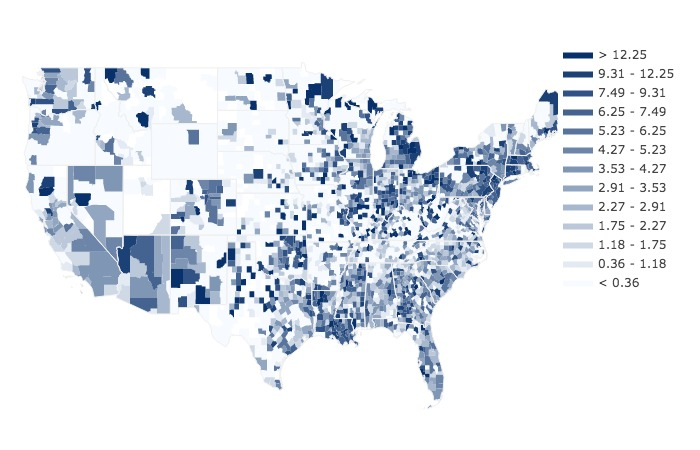

In [9]:
#Plotting COVID-19 mortality rate by county
plotMap(mortalityList)

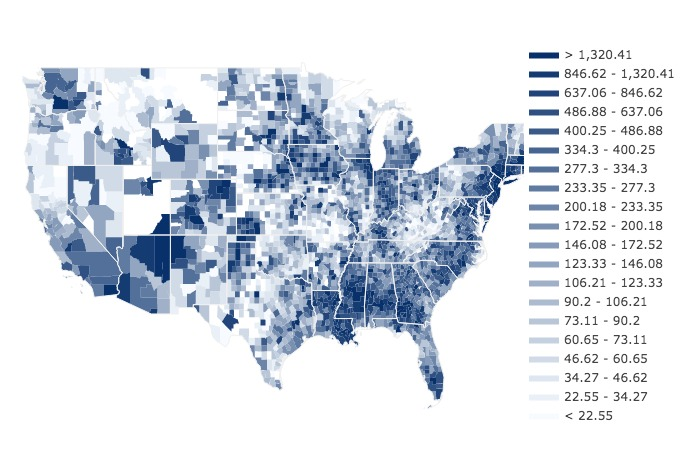

In [10]:
#Plotting confirmed cases per 100,000 people by county
plotMap(confirmPopList)

Although the mortality map might look rather scattered at a glance, the general pattern shows that there are 4 clusters in the US where the proportion of people that contract COVID-19 who die is unusually high -

1) North-East (specifically the Tri-State area)

2) The South-East (close to the Gulf of Mexico)

3) The Midwest 

4) The South-West (stretch from LA to New Mexico & Colorado)

These regions coincide with the map of the number of confirmed cases per 100,000 people.

#### Why does this make sense?
A county's healthcare system usually scales in size according to its population. If there are an unusually higher number of confirmed cases per 100,000 people, that also means that the healthcare system for those counties are most likely overwhelmed by COVID-19 patients. This spreads the resources of hospitals and doctors thin, often leading to some patients not getting the care they need, which then leads to a higher proportion of COVID-19 deaths per confirmed cases.

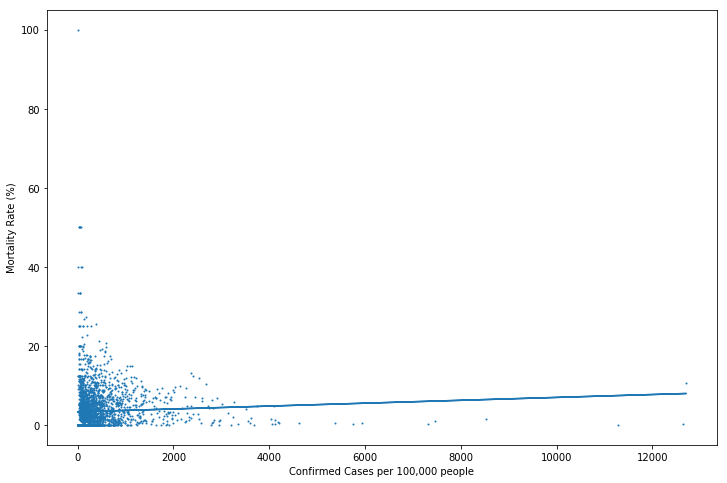

Correlation coefficient: 0.048235229425365005


In [11]:
#Plotting the confirmed cases per 100,000 people against the mortality rate
plt.rcParams["figure.figsize"] = (12, 8)

plt.xlabel("Confirmed Cases per 100,000 people")
plt.ylabel("Mortality Rate (%)")
plt.scatter(confirmPopList, mortalityList, 1)
plt.plot(confirmPopList, regLine(confirmPopList, mortalityList))
plt.show()

print("Correlation coefficient: " + str(coeff(confirmPopList, mortalityList)))

Although the correlation coefficient is positive like we expected it to be, it is very weak and could possibly be influeced by the outliers in the confirmPopList. Nevertheless, there does seem to be a very weak positive correlation between the two variables.

#### What next?
Even though the map of the mortality rate does have some geographic patterns, it is a little bit more scattered than I expected and I think that I might have to use another data feature for the rest of the analysis that will give stronger results.

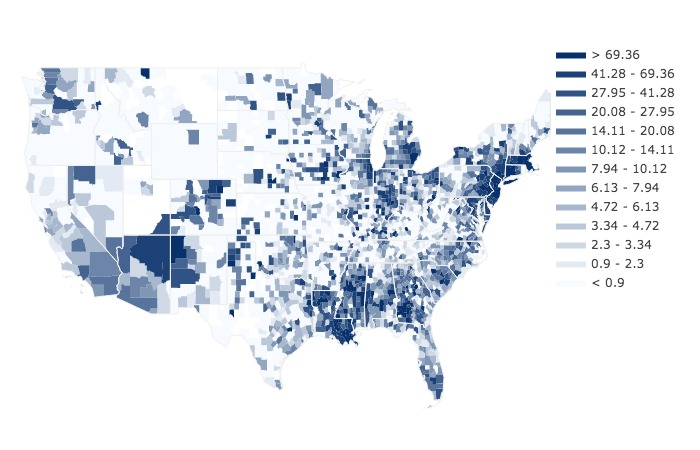

In [12]:
#Plotting deaths per 100,000 people by county
plotMap(deathPopList)

This map of deaths per 100,000 people shares a lot in common with the mortality map (same 4 geographic regions), but has much clearer geographic clusters, which could also be a result of the color scaling. However, there are not as many scattered counties on this map as on the mortality one and the patterns seem to be much more consistent on a regional basis.

The deaths per 100,000 people map coincides almost perfectly with the confirmed cases per 100,000 people, but this makes sense because the higher the number of confirmed cases, the higher number of deaths as well.

#### Next Stage
In the next steps of the analysis, I will compare non-pandemic factors related to the social and economic backgrounds of the counties with COVID-19 deaths per 100,000 people. I will focus on the same four regions/clusters -

1) North-East/Tri-State area

2) South-East

3) South-West

4) Midwest

### B. Economic Factors
This analysis specifically focuses on measures of economic health and stability such as the median household income, the poverty rate, and the unemployment rate.

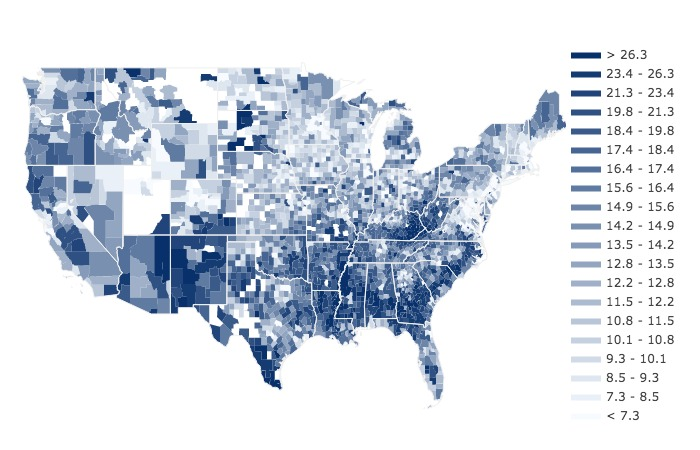

In [13]:
#Plotting the poverty rate by county
plotMap(povallList)

Looking at the poverty map above, there are two geographical regions from the deaths per 100,000 people map that coincide with this one - the South-West and the South-East. 

The North-East and the Midwest both have low poverty levels and their high death per population rates might be explained by their large number of big cities and industrial areas with high populations and population densities.

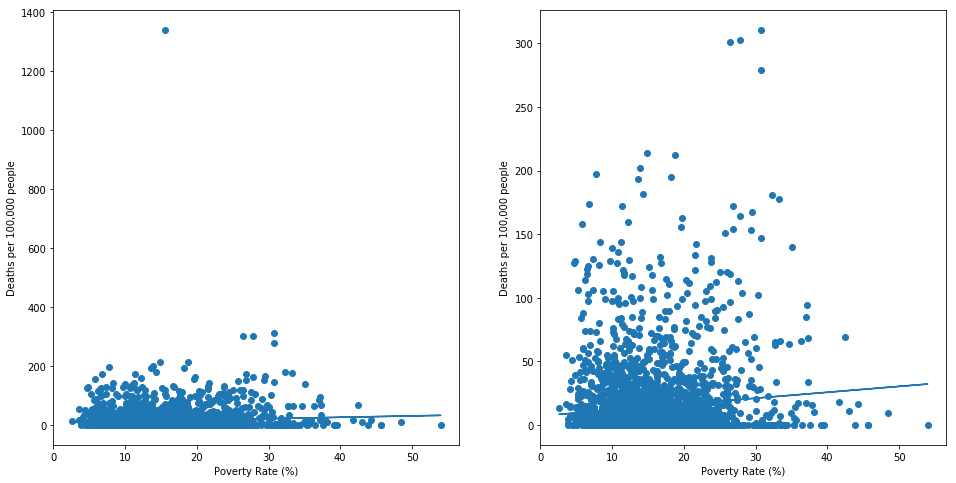

Correlation coefficient with Manhattan: 0.0765349380205149
Correlation coefficient without Manhattan: 0.09932415400505276


In [14]:
#Plotting poverty rate against the deaths per 100,000 people
plt.rcParams["figure.figsize"] = (16, 8)

plt.subplot(1, 2, 1)
plt.xlabel("Poverty Rate (%)")
plt.ylabel("Deaths per 100,000 people")
plt.scatter(povallList, deathPopList)
plt.plot(povallList, regLine(povallList, deathPopList))

plt.subplot(1, 2, 2)
plt.xlabel("Poverty Rate (%)")
plt.ylabel("Deaths per 100,000 people")
tempPov, tempDeaths = povallList[0 : 1750] + povallList[1751:], deathPopList[0 : 1750] + deathPopList[1751:]
plt.scatter(tempPov, tempDeaths)
plt.plot(tempPov, regLine(tempPov, tempDeaths))

plt.show()

print("Correlation coefficient with Manhattan: " + str(coeff(povallList, deathPopList)))
print("Correlation coefficient without Manhattan: " + str(coeff(tempPov, tempDeaths)))

Correlation coefficient without Manhattan and negligible counties: 0.28438631924524266

Number of counties in reduced list: 844 (28.523149712740793% of all 2959 counties)
% of total confirmed cases that reduced list is: 81.87396400106186
% of total population that reduced list is: 77.78341183247736


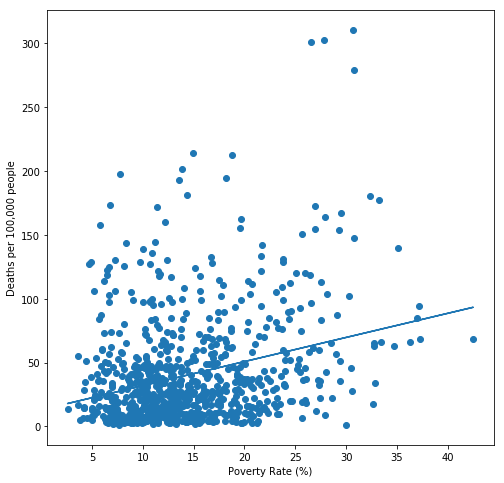

In [15]:
#Removing negligible counties
plt.rcParams["figure.figsize"] = (8, 8)

x, y = reduce(povallList), reduce(deathPopList)
plt.xlabel("Poverty Rate (%)")
plt.ylabel("Deaths per 100,000 people")
plt.scatter(x, y)
plt.plot(x, regLine(x, y))

print("Correlation coefficient without Manhattan and negligible counties: " + str(coeff(x, y)) + "\n")
print("Number of counties in reduced list: " + str(len(x)) + " (" + str(len(x) / 2959 * 100) + "% of all 2959 counties)")
print("% of total confirmed cases that reduced list is: " + str(sum(reduce(confirmedList)) / sum(confirmedList) * 100))
print("% of total population that reduced list is: " + str(sum(reduce(popList)) / sum(popList) * 100))

#### Important Note - Why remove Manhatthan Borough/New York County?
As can be seen in the first plot and the difference in correlation coefficients, Manhattan (New York City in the list) is an extreme outlier with a drastically higher number of deaths per 100,000 people, primarily due to its very high population density. 

For this reason, I will not include Manhattan in the other graphs going forward. It will ensure that the data remains more reflective of the country as a whole and will also be useful to show the effect of outliers in the final analysis.

#### Important Note - Why remove so many counties?
Yes. I know it looks like I'm removing 70% of the 2959 counties, but if you take a closer look, you can see why it is being done. Despite being only 28% of the original counties, the 844 counties in the reduced list make up 77% of the total population and 81% of the total confirmed cases! It also increased the correlation coefficient by about 0.18! This means one thing - all those counties with 10 or less cases and 5 or less deaths were skewing the data and manipulating the big picture a lot. They were accounting for a negligible amount of cases and deaths while taking up a lot of data points which skewed the regression line. This is why I will work with the reduced lists going forward (only in graphs, not in maps). If you try this yourself, you can change the reduce function with any numbers you want. 10 and 5 are just numbers that I chose after looking at the percentiles.

#### Poverty - Why does this make sense?
As can be seen from the graphs above and the correlation coefficients, there is a weak positive correlation between the poverty level and the deaths per 100,000 people. This could be explained by the fact that people in poorer counties don't have access to the best healthcare and in addition to this, they often have to go out for their jobs and don't have the comfort of working at home, exposing them to the virus more than usual.

The patterns are already looking stronger and I will continue this same process for the rest of the factors, combining all of them in the final analysis.

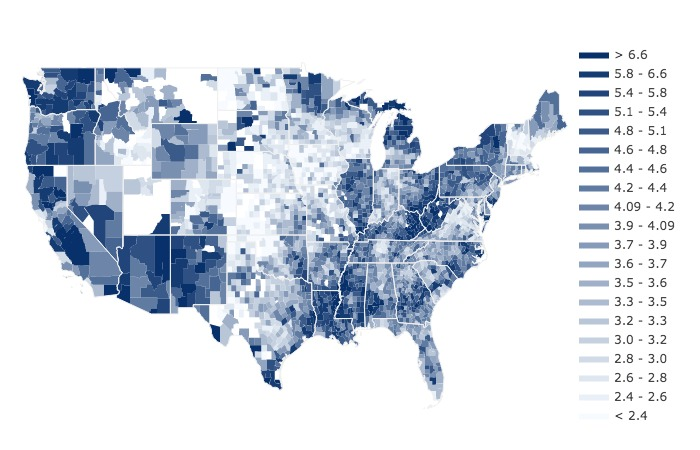

In [16]:
#Plotting the unemployment rate by county
plotMap(unemployList)

Looking at the unemployment map above, there are three geographical regions from the deaths per 100,000 people map that coincide with this one - the South-West, the South-East, and the Midwest (somewhat).

The South's high poverty rate makes sense that it also has a high unemployment rate; the same goes for the South-West. Being unemployed means that more people go out to look for jobs and are willing to work with anything they can find, often venturing out more than others so that they can put food on the table - exposing them even more to the virus which is especially bad considering this group of people doesn't have access to affordable healthcare.

The reason I said "somewhat" for the Midwest is that although some parts of the region have high unemployment rates due to the shutdown of the industries there (not West Virginia, which is below the Midwestern states), Indiana seems to be faring better than its counterparts, especially when considering its high density of counties with high COVID-19 death rates.

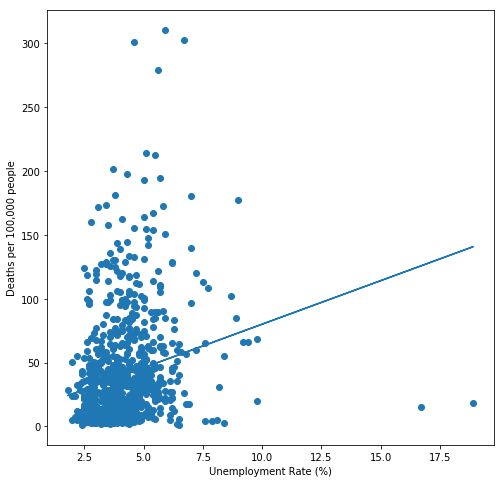

Correlation coefficient: 0.2173641427403973


In [17]:
#Plotting unemployment rate against deaths per 100,000 people
plt.rcParams["figure.figsize"] = (8, 8)

x, y = reduce(unemployList), reduce(deathPopList)
plt.xlabel("Unemployment Rate (%)")
plt.ylabel("Deaths per 100,000 people")
plt.scatter(x, y)
plt.plot(x, regLine(x, y))
plt.show()

print("Correlation coefficient: " + str(coeff(x, y)))

#### Unemployment - Why does this make sense?
As can be seen from the graph above and the correlation coefficient, there is a weak positive correlation between the unemployment rate and the deaths per 100,000 people. This can be explained by the same reason for which counties with high poverty levels have higher death rates as well - poor access to quality healthcare and venturing out for work.

Although the graph above appears to be normally distributed, the data points above 50 deaths per 100,000 people are a tiny fraction of the total counties and the regression line is appropriate for a majority of the data points.

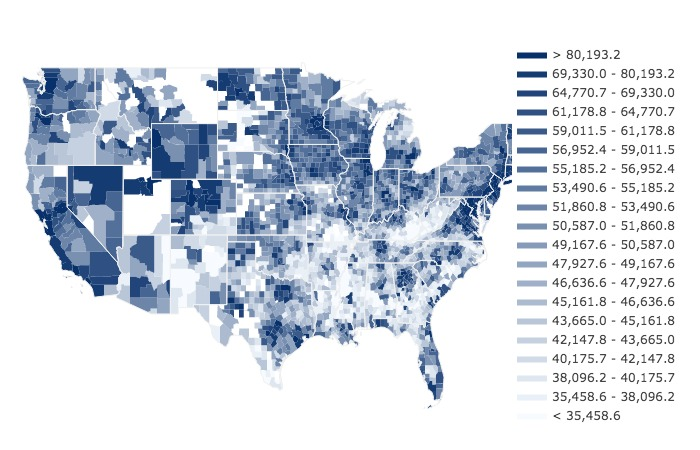

In [18]:
#Plotting the median household income by county
plotMap(medianList)

Looking at the median income map above, it is clear that the two regions that coincide with the deaths per 100,000 people map are the Midwest and the North-East.

Although these two regions have high median household incomes which I would instinctively think would decrease deaths, their high death per capita rates might be explained by higher populations and larger cities with higher population densities. It is difficult to tell from the map how the median income affects death rates on the large scale with all 844 counties, which is what we will look at with the graphs below.

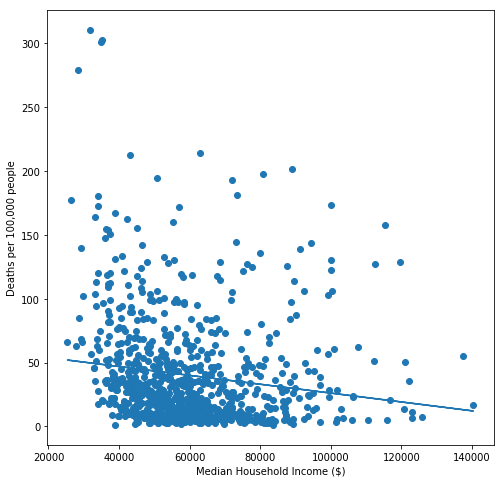

Correlation coefficient: -0.14529399999514267


In [19]:
#Plotting median household income against deaths per 100,000 people
plt.rcParams["figure.figsize"] = (8, 8)

x, y = reduce(medianList), reduce(deathPopList)
plt.xlabel("Median Household Income ($)")
plt.ylabel("Deaths per 100,000 people")
plt.scatter(x, y)
plt.plot(x, regLine(x, y))
plt.show()

print("Correlation coefficient: " + str(coeff(x, y)))

#### Median Household Income - Why does this make sense?
There is a weak negative correlation between the median income and deaths per 100,000 people, nearing about -0.15, but lower in magnitude than the coefficients for poverty and unemployment.

The reason this trend exists is because counties with higher median incomes tend to have a larger proportion of people that can work from home (tech jobs) as well as improved affordable access to quality healthcare. Both these factors translate to a lower number of people being exposed to the virus as well as adequate medical attention for those who do contract the virus, leading to a lower death per population rate.

### C. Racial Disparities
This analysis specifically focuses on the racial makeup of a county's population.

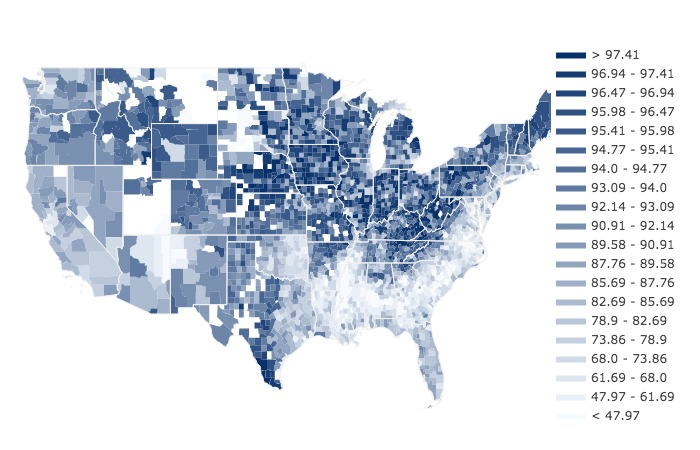

In [20]:
#Plotting white alone % by county
plotMap(whiteAlone)

As can be seen from the map above, there is an overwhelming white majority in all of the Midwest and the Western US. The only region which coincides with the death per 100,000 people map is the Midwest. Overall, I would expect the deaths per 100,000 people to decrease as the percentage of people that identify as White Alone increases since counties in the Appalachians and west of the Mississippi River have very low death rates.

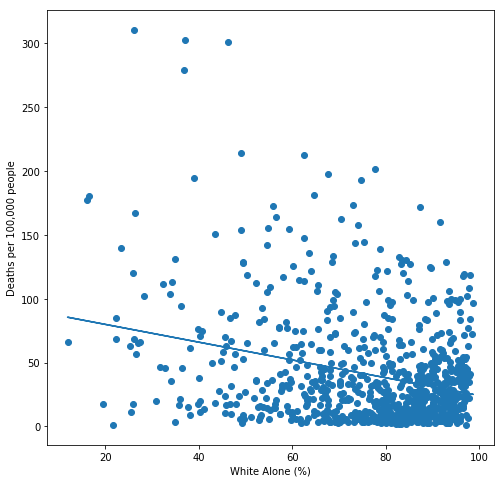

Correlation coefficient: -0.2850302980686117


In [21]:
#Plotting white alone % against deaths per 100,000 people
plt.rcParams["figure.figsize"] = (8, 8)

x, y = reduce(whiteAlone), reduce(deathPopList)
plt.xlabel("White Alone (%)")
plt.ylabel("Deaths per 100,000 people")
plt.scatter(x, y)
plt.plot(x, regLine(x, y))
plt.show()

print("Correlation coefficient: " + str(coeff(x, y)))

#### White Alone % - Why does this make sense?
As I expected, there is a weak negative correlation between the proportion of white residents in a county and the deaths per 100,000 people. This could be explained by the fact that a majority of counties with higher proportions of white residents tend to be either in the Appalachian Mountains or west of the Mississippi river where the population density is very low and therefore, the number of people infected would be lower as well. In addition, due to the US' history as a nation divided along race lines, counties with higher proportions of white residents also tend to be wealthier, having better access to healthcare.

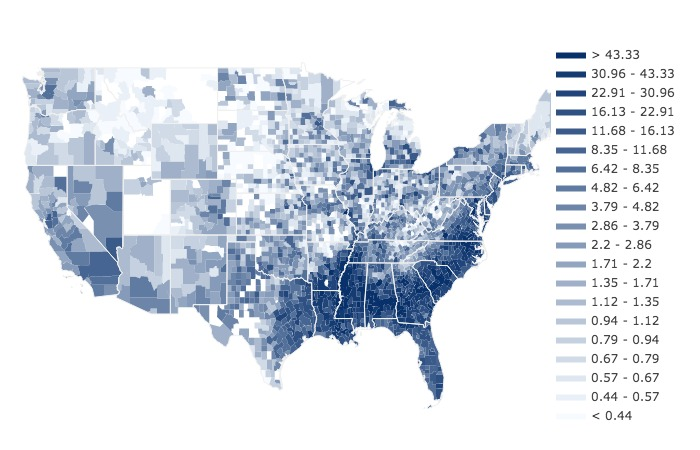

In [22]:
#Plotting black alone % by county
plotMap(blackAlone)

As can be seen from the map above, the nation's southern states have much higher proportions of African-American residents than the rest of the states and this directly coincides with the maps that show the South having lower median incomes, higher unemployment rates, and higher poverty levels. All of this can be explained by the United States' sad and cruel history of slavery and the oppression of the African-American community.

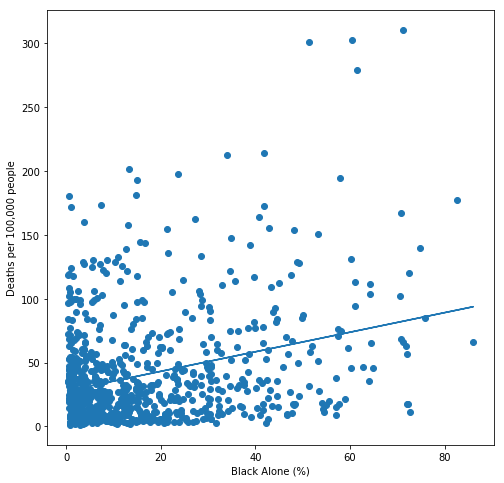

Correlation coefficient: 0.3076084194776888


In [23]:
#Plotting black alone % against deaths per 100,000 people
plt.rcParams["figure.figsize"] = (8, 8)

x, y = reduce(blackAlone), reduce(deathPopList)
plt.xlabel("Black Alone (%)")
plt.ylabel("Deaths per 100,000 people")
plt.scatter(x, y)
plt.plot(x, regLine(x, y))
plt.show()

print("Correlation coefficient: " + str(coeff(x, y)))

#### Black Alone % - Why does this make sense?
There is a weak positive correlation between the proportion of African-American residents and the deaths per 100,000 people. Due to the systemic oppression of the African-American community for hundreds of years, their community has faced high poverty and unemployment as well as low median incomes. This translates to many people often having to go out to find work, exposing them to the virus more and since they don't have access to quality healthcare, this in turn leads to higher death rates.

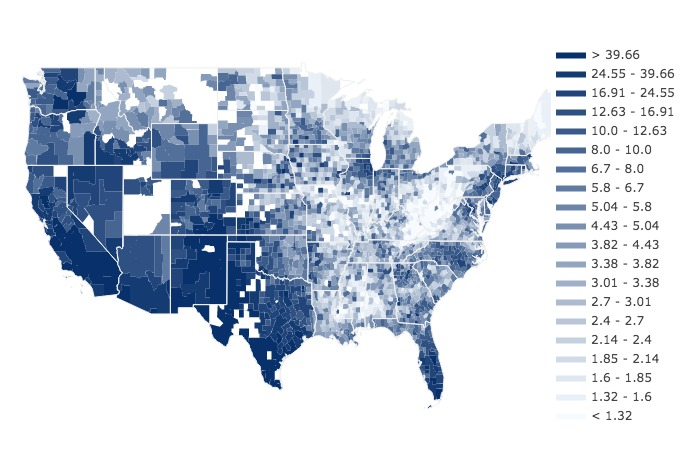

In [24]:
#Plotting hispanic % by county
plotMap(hispanic)

As can be seen from the map above, almost all counties with higher proportions of hispanic residents are in the Western States since they are much closer to Mexico. Although these counties do coincide with the small region in the South-West which has higher death rates, most of these counties are located in places with harsher climates (desert) and have lower population densities.

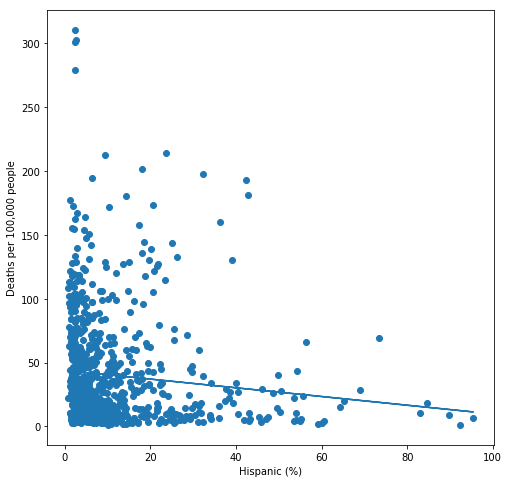

Correlation coefficient: -0.10449343044286291


In [25]:
#Plotting hispanic % against deaths per 100,000 people
plt.rcParams["figure.figsize"] = (8, 8)

x, y = reduce(hispanic), reduce(deathPopList)
plt.xlabel("Hispanic (%)")
plt.ylabel("Deaths per 100,000 people")
plt.scatter(x, y)
plt.plot(x, regLine(x, y))
plt.show()

print("Correlation coefficient: " + str(coeff(x, y)))

#### Hispanic % - Why does this make sense?
There is a weak negative correlation between the proportion of Hispanic residents and the deaths per 100,000 people, which is lower in magnitude than the other correlations above. This can be explained by most of these counties having lower population densities as mentioned above.

#### Important Note 
This DOES NOT mean that the Hispanic community is spared from the worst of the pandemic. This correlation does not show that the Hispanic community in high density places such as New York City is severely affected by COVID-19. This graph merely shows a correlation, not the actual situation of the community.

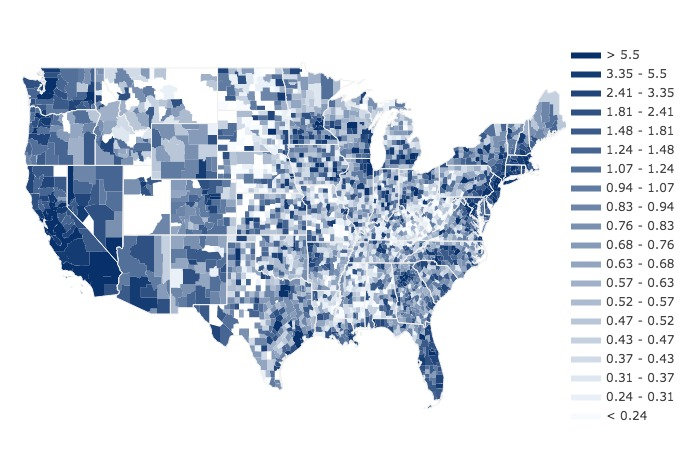

In [26]:
#Plotting asian alone % by county
plotMap(asianAlone)

As can be seen from the map above, the Asian community is scattered across the country, but is mostly clustered in large cities and metropolitan areas such as Dallas, Austin, Houston, LA, the Bay Area, Atlanta, and the Tri-State area. These places have higher population densities, but also have higher median incomes and lower poverty levels.

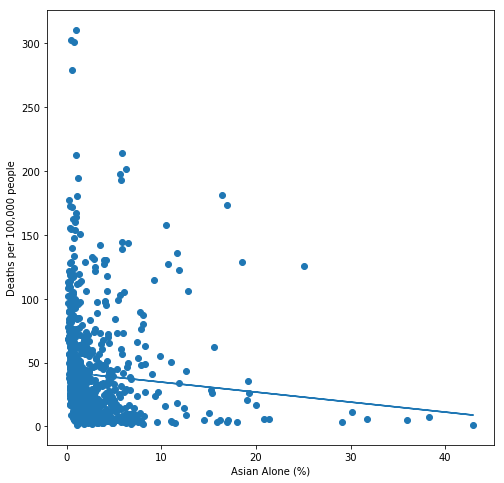

Correlation coefficient: -0.0786676559809728


In [27]:
#Plotting asian alone % against deaths per 100,000 people
plt.rcParams["figure.figsize"] = (8, 8)

x, y = reduce(asianAlone), reduce(deathPopList)
plt.xlabel("Asian Alone (%)")
plt.ylabel("Deaths per 100,000 people")
plt.scatter(x, y)
plt.plot(x, regLine(x, y))
plt.show()

print("Correlation coefficient: " + str(coeff(x, y)))

#### Asian Alone % - Why does this make sense?
There is a weak negative correlation between the proportion of Asian American residents and the deaths per 100,000 people (possibly skewed by all the lower proportion points). The low value of the coefficient can be explained by the fact that counties with higher proportions of Asian American residents both tend to be larger/populous cities (more exposure to the virus) and also have higher incomes and lower poverty levels (better healthcare).

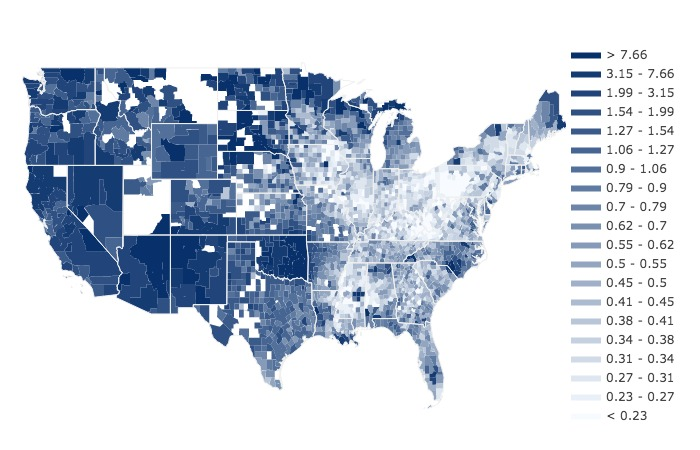

In [28]:
#Plotting Native American alone % by county
plotMap(nativeAlone)

As can be seen from the map above, the counties with higher proportions of Native American residents are all mostly located west of the Mississippi river due to the expansionist policies of the US in the 1800s. There are a few counties with very high proportions of Native Americans along the Northern border between Arizona and New Mexico which coincide with high death per capita rates in those counties.

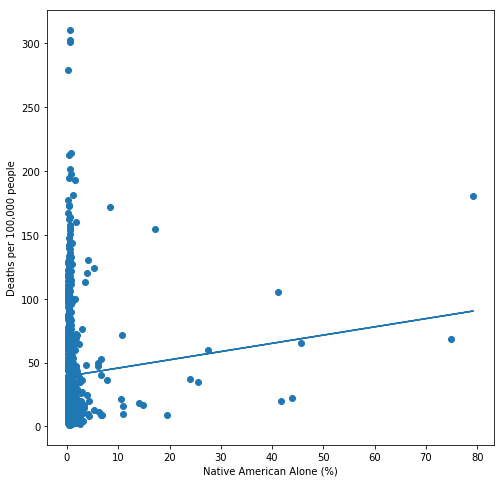

Correlation coefficient: 0.0782437546363021


In [29]:
#Plotting Native American alone % against deaths per 100,000 people
plt.rcParams["figure.figsize"] = (8, 8)

x, y = reduce(nativeAlone), reduce(deathPopList)
plt.xlabel("Native American Alone (%)")
plt.ylabel("Deaths per 100,000 people")
plt.scatter(x, y)
plt.plot(x, regLine(x, y))
plt.show()

print("Correlation coefficient: " + str(coeff(x, y)))

#### Native American Alone % - Why does this make sense?
There is a weak positive correlation between the proportion of Native American residents and the number of deaths per 100,000 people. This can be explained by the fact that counties with higher proportions of Native Americans, such as the reservation in Arizona & New Mexico, usually have higher poverty and unemployment in addition to most Native Americans having no natural immunity against foreign viruses. The low coefficient value is most likely due to the several low proportion data points which could possibly be skewing the regression line as well.

### D. Educational Factors
This analysis specifically focuses on different types of educational backgrounds in a population.

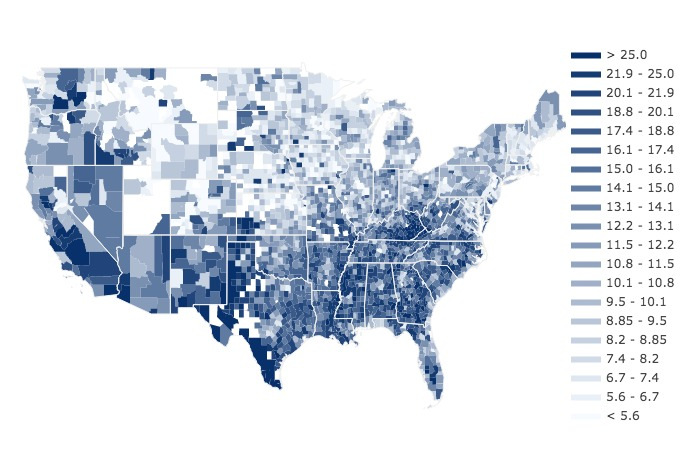

In [30]:
#Plotting less than a high school diploma % by county
plotMap(lessHigh)

As can be seen from the map above, the counties with higher proportions of adults not completing high school are mainly in the Southern States where poverty and unemployment is higher. These counties also have higher proportions of Hispanic and African American residents.

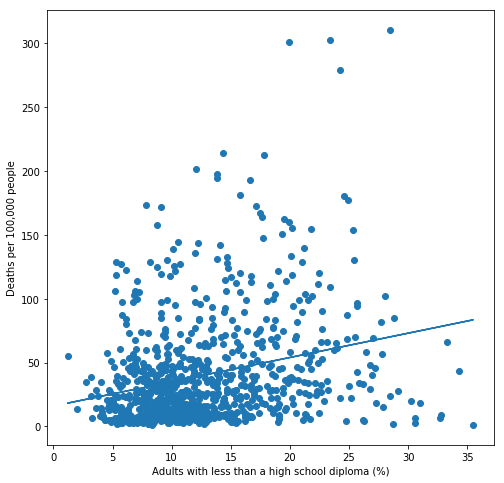

Correlation coefficient: 0.2600699855970812


In [31]:
#Plotting less than a high school diploma % against deaths per 100,000 people
plt.rcParams["figure.figsize"] = (8, 8)

x, y = reduce(lessHigh), reduce(deathPopList)
plt.xlabel("Adults with less than a high school diploma (%)")
plt.ylabel("Deaths per 100,000 people")
plt.scatter(x, y)
plt.plot(x, regLine(x, y))
plt.show()

print("Correlation coefficient: " + str(coeff(x, y)))

#### Less than a high school diploma % - Why does this make sense?
There is a weak positive correlation between the proportion of adults not completing high school and the number of deaths per 100,000 people. This is because adults that don't complete high school only have the qualifications and skills for low level jobs, thereby increasing poverty and unemployment. This especially correlates with the South-Eastern region/cluster on the deaths per capita map.

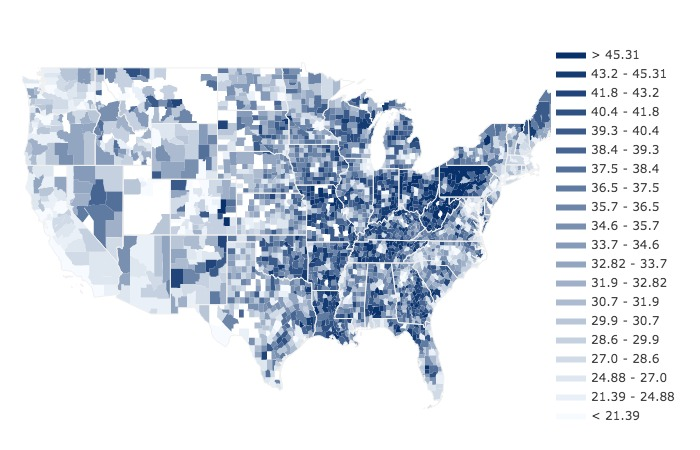

In [32]:
#Plotting only a high school diploma % by county
plotMap(onlyHigh)

As can be seen from the map above, the counties with higher proportions of adults that only have high school diplomas are located mostly in the Midwest and South-Eastern states. This is most likely due to the large manufacturing industries in the Midwest and also recently in the South, which don't require more than a high school education.

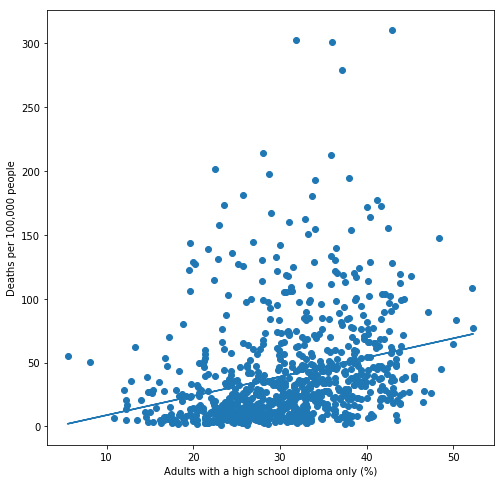

Correlation coefficient: 0.2675487389828141


In [33]:
#Plotting only a high school diploma % against deaths per 100,000 people
plt.rcParams["figure.figsize"] = (8, 8)

x, y = reduce(onlyHigh), reduce(deathPopList)
plt.xlabel("Adults with a high school diploma only (%)")
plt.ylabel("Deaths per 100,000 people")
plt.scatter(x, y)
plt.plot(x, regLine(x, y))
plt.show()

print("Correlation coefficient: " + str(coeff(x, y)))

#### Only a high school diploma % - Why does this make sense?
There is a weak positive correlation between the proportion of adults with a high school diploma only and the number of deaths per 100,000 people. This is also because adults with a high school diploma only tend to work in blue-collar industries, where access to healthcare is scarce and working from home isn't an option. This overlaps with both the Midwest and South-East regions, which both have counties with higher numbers of deaths per capita.

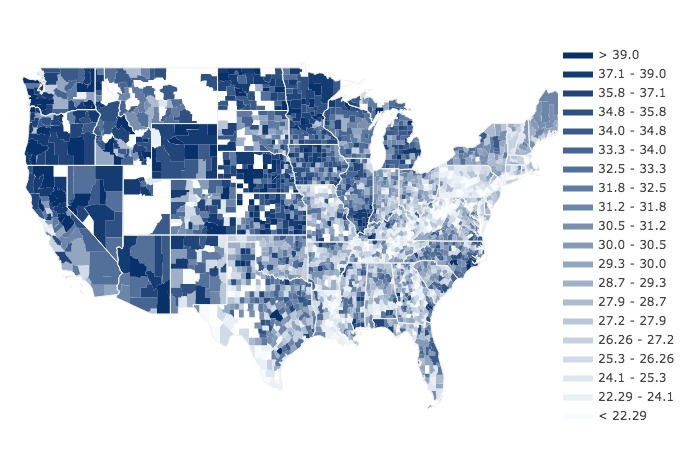

In [34]:
#Plotting some college/associate's degree % by county
plotMap(someCollege)

As can be seen from the map above, the counties with higher proportions of adults with some college/an associate's degree are mostly located in the Western states. These regions have low populations and population densities as well as lower unemployment and poverty rates.

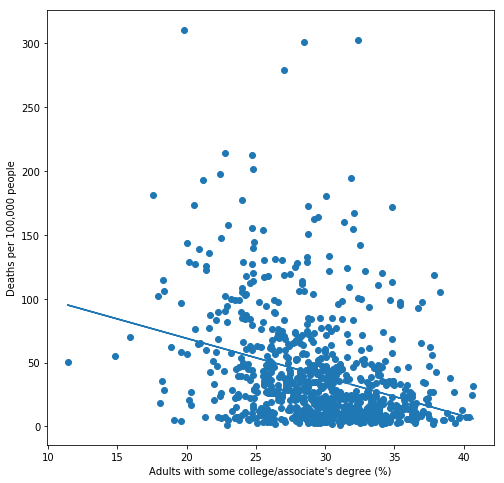

Correlation coefficient: -0.31029037163193895


In [35]:
#Plotting some college/associate's degree % against deaths per 100,000 people
plt.rcParams["figure.figsize"] = (8, 8)

x, y = reduce(someCollege), reduce(deathPopList)
plt.xlabel("Adults with some college/associate's degree (%)")
plt.ylabel("Deaths per 100,000 people")
plt.scatter(x, y)
plt.plot(x, regLine(x, y))
plt.show()

print("Correlation coefficient: " + str(coeff(x, y)))

#### Some college/associate's degree % - Why does this make sense?
There is a weak negative correlation between the proportion of adults with some college/an associate's degree and the number of deaths per 100,000 people. This could be explained by the fact that most of these counties are located in the West where the population density is much lower than other states, thereby exposing less people to the virus. Also, adults with some college/an associate's degree are usually qualified for higher paying jobs and have better access to healthcare.

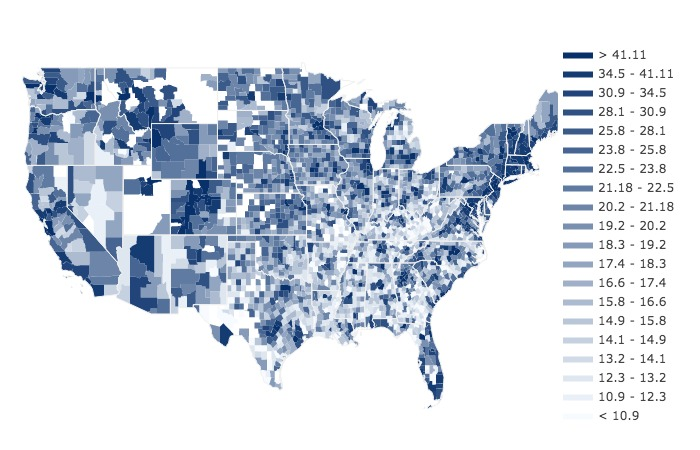

In [36]:
#Plotting bachelor's degree or higher % by county
plotMap(bachelorAbove)

As can be seen from the map above, counties with higher proportions of adults with bachelor's degrees or higher are mostly located in metropolitan areas/cities such as Houston, Atlanta, the Bay area, the Tri-State area, etc. Although these places do have higher population densities, they also tend to be wealthier in general.

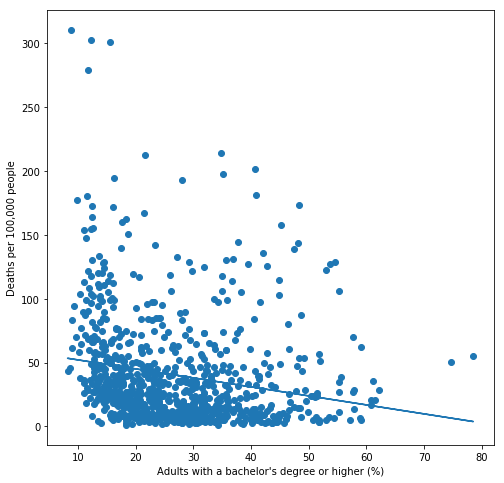

Correlation coefficient: -0.19040500522530998


In [37]:
#Plotting bachelor's degree or higher % against deaths per 100,000 people
plt.rcParams["figure.figsize"] = (8, 8)

x, y = reduce(bachelorAbove), reduce(deathPopList)
plt.xlabel("Adults with a bachelor's degree or higher (%)")
plt.ylabel("Deaths per 100,000 people")
plt.scatter(x, y)
plt.plot(x, regLine(x, y))
plt.show()

print("Correlation coefficient: " + str(coeff(x, y)))

#### Bachelor's degree or higher % - Why does this make sense?
There is a weak negative correlation between the proportion of adults with bachelor's degrees or higher and the number of deaths per 100,000 people. This value is lower in magnitude than the other coefficients most likely due to the fact that the Tri-State area is a cluster with a high proportion of adults with bachelor's degrees or higher, but is also a hotspot for COVID-19 and has counties with high death rates.

### E. Other Correlations
This analysis finds correlations between several different variables that are not all related to the pandemic.
I will not be using the reduced lists for this as I won't be plotting any case information.

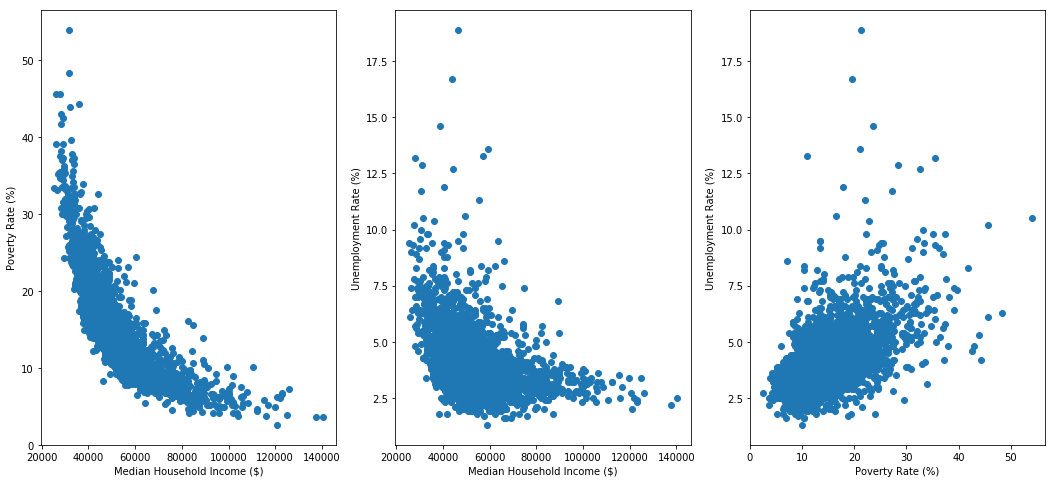

In [38]:
#Plotting relationships between economic factors
plt.rcParams["figure.figsize"] = (18, 8)

plt.subplot(1, 3, 1)
plt.xlabel("Median Household Income ($)")
plt.ylabel("Poverty Rate (%)")
plt.scatter(medianList, povallList)

plt.subplot(1, 3, 2)
plt.xlabel("Median Household Income ($)")
plt.ylabel("Unemployment Rate (%)")
plt.scatter(medianList, unemployList)

plt.subplot(1, 3, 3)
plt.xlabel("Poverty Rate (%)")
plt.ylabel("Unemployment Rate (%)")
plt.scatter(povallList, unemployList)

plt.show()

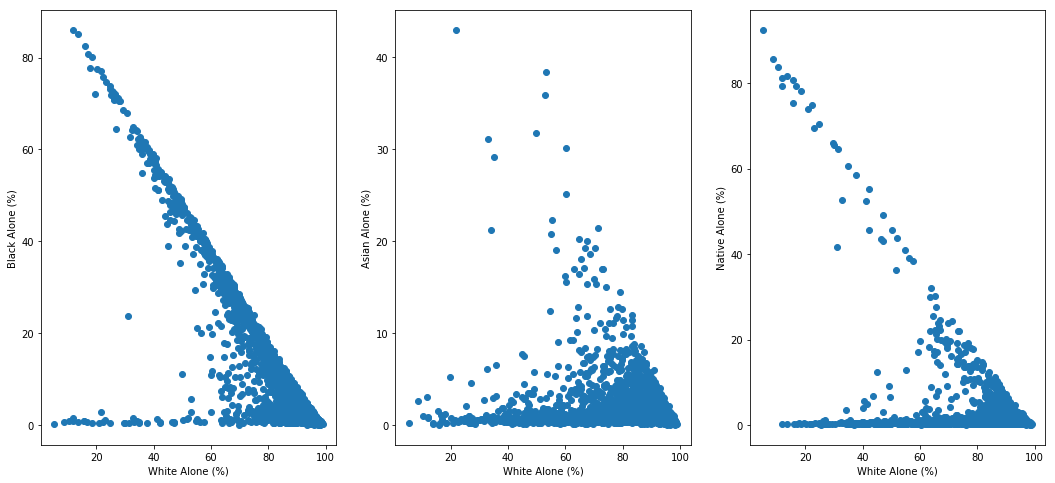

In [39]:
#Plotting relationships between demographic factors (only significant correlations plotted)
plt.rcParams["figure.figsize"] = (18, 8)

plt.subplot(1, 3, 1)
plt.xlabel("White Alone (%)")
plt.ylabel("Black Alone (%)")
plt.scatter(whiteAlone, blackAlone)

plt.subplot(1, 3, 2)
plt.xlabel("White Alone (%)")
plt.ylabel("Asian Alone (%)")
plt.scatter(whiteAlone, asianAlone)

plt.subplot(1, 3, 3)
plt.xlabel("White Alone (%)")
plt.ylabel("Native Alone (%)")
plt.scatter(whiteAlone, nativeAlone)

plt.show()

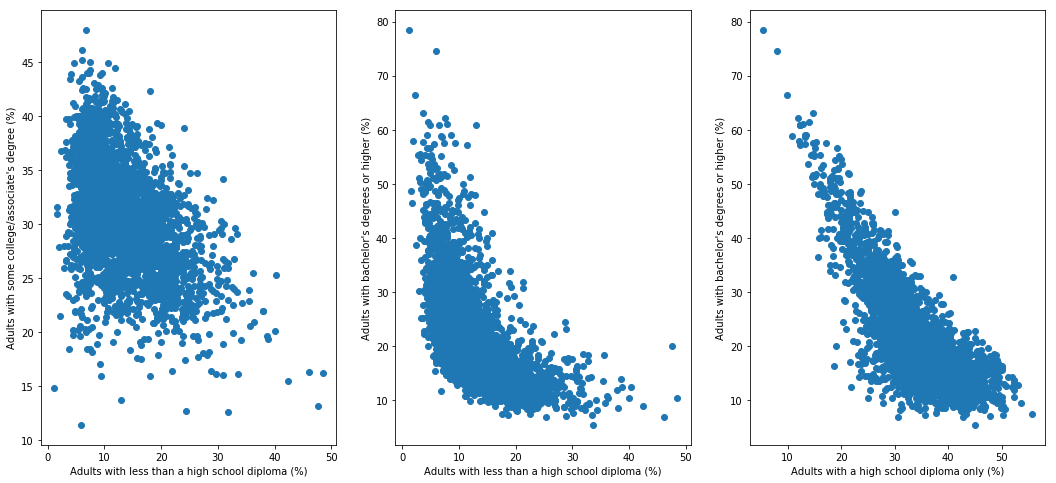

In [40]:
#Plotting relationships between educational factors (only significant correlations plotted)
plt.rcParams["figure.figsize"] = (18, 8)

plt.subplot(1, 3, 1)
plt.xlabel("Adults with less than a high school diploma (%)")
plt.ylabel("Adults with some college/associate's degree (%)")
plt.scatter(lessHigh, someCollege)

plt.subplot(1, 3, 2)
plt.xlabel("Adults with less than a high school diploma (%)")
plt.ylabel("Adults with bachelor's degrees or higher (%)")
plt.scatter(lessHigh, bachelorAbove)

plt.subplot(1, 3, 3)
plt.xlabel("Adults with a high school diploma only (%)")
plt.ylabel("Adults with bachelor's degrees or higher (%)")
plt.scatter(onlyHigh, bachelorAbove)

plt.show()

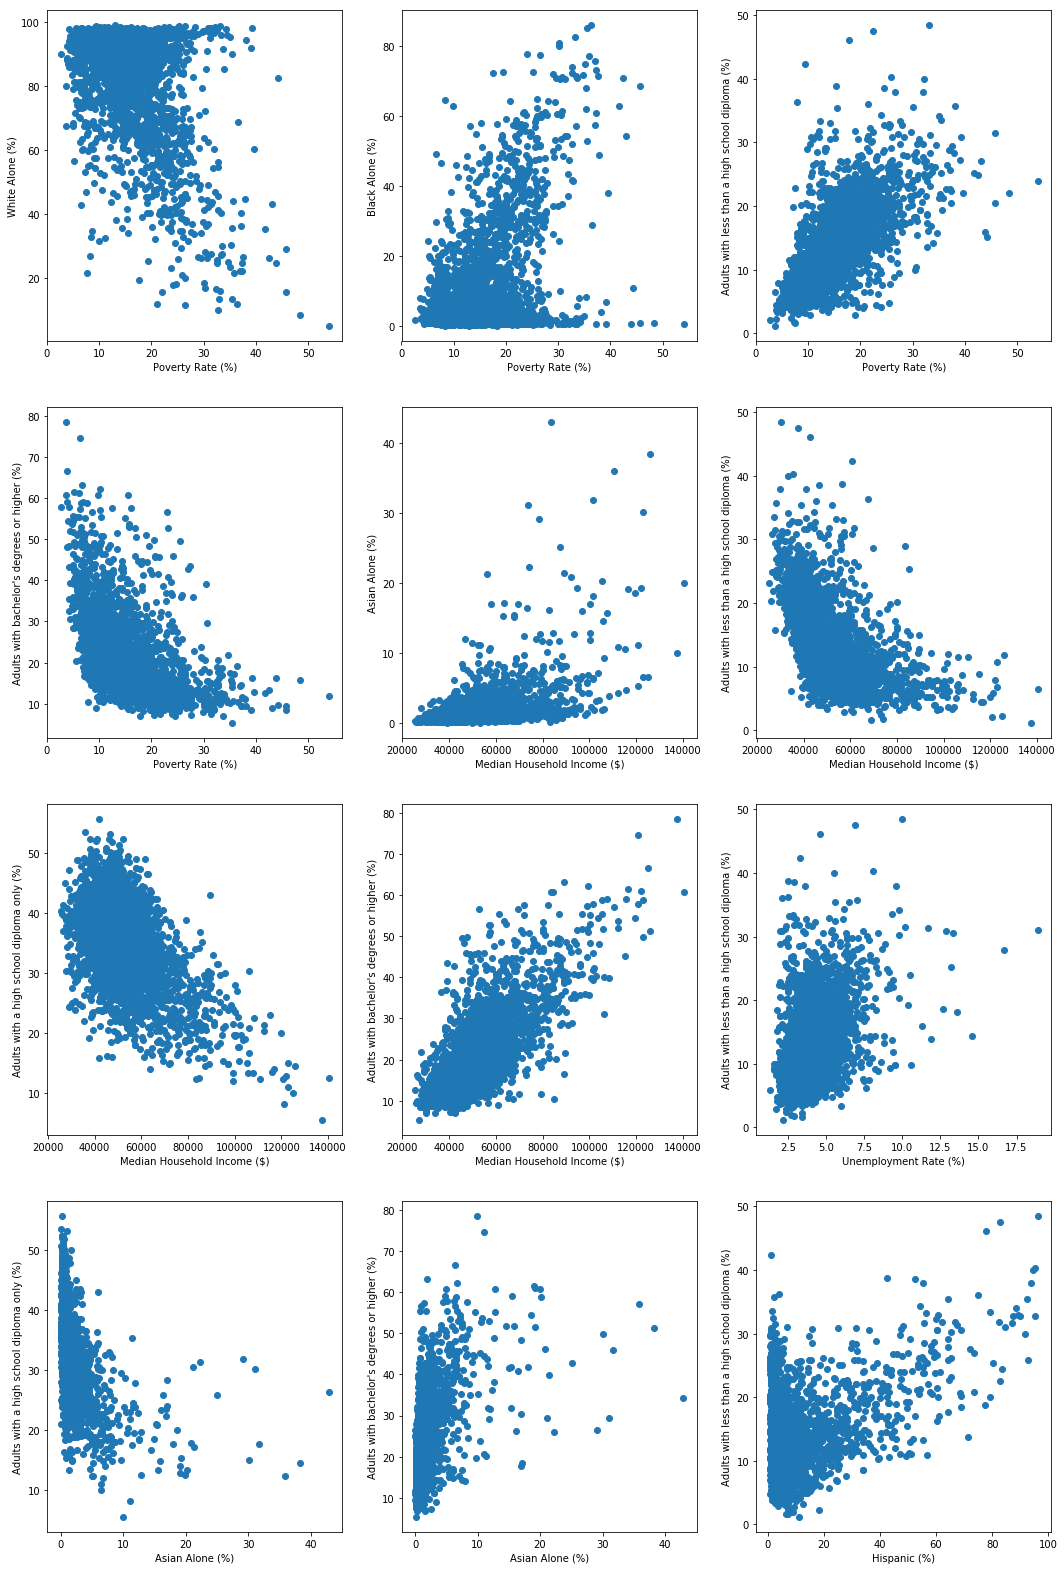

In [41]:
#Plotting other relationships (only significant ones plotted)

plt.rcParams["figure.figsize"] = (18, 28)

plt.subplot(4, 3, 1)
plt.xlabel("Poverty Rate (%)")
plt.ylabel("White Alone (%)")
plt.scatter(povallList, whiteAlone)

plt.subplot(4, 3, 2)
plt.xlabel("Poverty Rate (%)")
plt.ylabel("Black Alone (%)")
plt.scatter(povallList, blackAlone)

plt.subplot(4, 3, 3)
plt.xlabel("Poverty Rate (%)")
plt.ylabel("Adults with less than a high school diploma (%)")
plt.scatter(povallList, lessHigh)

plt.subplot(4, 3, 4)
plt.xlabel("Poverty Rate (%)")
plt.ylabel("Adults with bachelor's degrees or higher (%)")
plt.scatter(povallList, bachelorAbove)

plt.subplot(4, 3, 5)
plt.xlabel("Median Household Income ($)")
plt.ylabel("Asian Alone (%)")
plt.scatter(medianList, asianAlone)

plt.subplot(4, 3, 6)
plt.xlabel("Median Household Income ($)")
plt.ylabel("Adults with less than a high school diploma (%)")
plt.scatter(medianList, lessHigh)

plt.subplot(4, 3, 7)
plt.xlabel("Median Household Income ($)")
plt.ylabel("Adults with a high school diploma only (%)")
plt.scatter(medianList, onlyHigh)

plt.subplot(4, 3, 8)
plt.xlabel("Median Household Income ($)")
plt.ylabel("Adults with bachelor's degrees or higher (%)")
plt.scatter(medianList, bachelorAbove)

plt.subplot(4, 3, 9)
plt.xlabel("Unemployment Rate (%)")
plt.ylabel("Adults with less than a high school diploma (%)")
plt.scatter(unemployList, lessHigh)

plt.subplot(4, 3, 10)
plt.xlabel("Asian Alone (%)")
plt.ylabel("Adults with a high school diploma only (%)")
plt.scatter(asianAlone, onlyHigh)

plt.subplot(4, 3, 11)
plt.xlabel("Asian Alone (%)")
plt.ylabel("Adults with bachelor's degrees or higher (%)")
plt.scatter(asianAlone, bachelorAbove)

plt.subplot(4, 3, 12)
plt.xlabel("Hispanic (%)")
plt.ylabel("Adults with less than a high school diploma (%)")
plt.scatter(hispanic, lessHigh)

plt.show()

### F. Final Analysis
This combines all the factors above and correlates it with the deaths per 100,000 people to give the big picture.

To do this, I will min-max normalize all of the input lists on a scale of 0 to 1. Then I will multiply each value in the lists by their respective correlation coefficients which will weight them by importance. Finally, I will add all of the lists together to create a combined socio-economic index.

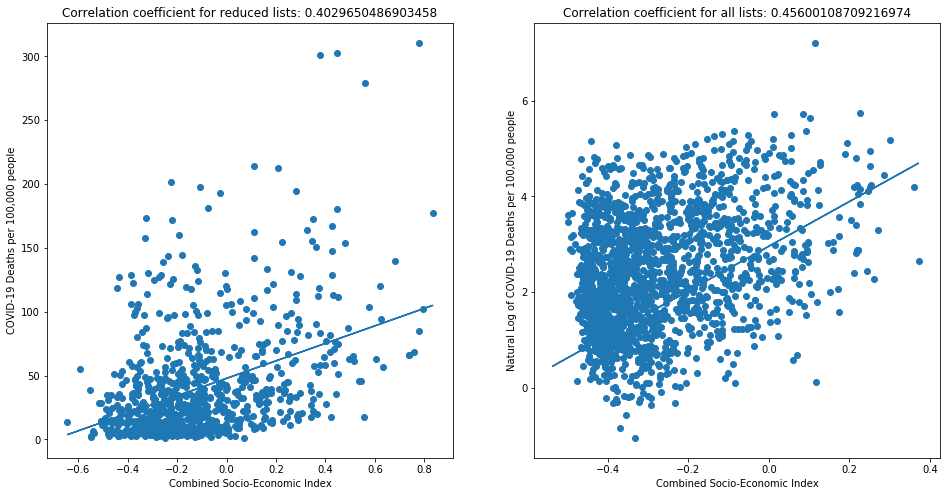

In [42]:
#Plotting combined index against deaths per 100,000 people
plt.rcParams["figure.figsize"] = (16, 8)

allLists = [povallList, unemployList, medianList, whiteAlone, blackAlone, hispanic, asianAlone, nativeAlone, lessHigh, onlyHigh, someCollege, bachelorAbove]
allCoeff = []


#Reduced lists against deaths per 100,000 people
y = reduce(deathPopList)
for i in range(len(allLists)):
    allCoeff.append(coeff(normalize(reduce(allLists[i])), y))

combinedIndex = np.array([0 for i in range(len(y))])
for i in range(len(allLists)):
    combinedIndex = combinedIndex + (allCoeff[i] * normalize(reduce(allLists[i])))

plt.subplot(1, 2, 1)
plt.xlabel("Combined Socio-Economic Index")
plt.ylabel("COVID-19 Deaths per 100,000 people")
plt.title("Correlation coefficient for reduced lists: " + str(coeff(combinedIndex, y)))
plt.scatter(combinedIndex, y)
plt.plot(combinedIndex, regLine(combinedIndex, y))


#All 2959 counties combined index against natural log of number of deaths per 100,000 people
y = ma.log(deathPopList)
allCoeff.clear()
for i in range(len(allLists)):
    allCoeff.append(coeff(normalize(allLists[i]), y))

combinedIndex = np.array([0 for i in range(len(y))])
for i in range(len(allLists)):
    combinedIndex = combinedIndex + (allCoeff[i] * normalize(allLists[i]))

plt.subplot(1, 2, 2)
plt.xlabel("Combined Socio-Economic Index")
plt.ylabel("Natural Log of COVID-19 Deaths per 100,000 people")
plt.title("Correlation coefficient for all lists: " + str(coeff(combinedIndex, y)))
plt.scatter(combinedIndex, y)
plt.plot(combinedIndex, regLine(combinedIndex, y))


plt.show()

#### Why does this make sense?
There is a moderate positive correlation between the combined index for the reduced lists and the number of deaths per 100,000 people. On the right side, I included all counties, but to account for the negligible counties and Manhattan being an extreme outlier, I plotted the combined index for all the counties against the natural log of the number of deaths per 100,000 people (counties with death rates of 0 were masked). As can be seen, after combining all the variables into a comprehensive index, there is a clearly a correlation between all of them and the number of deaths per 100,000 people. Both graphs have a cluster of counties with low death per capita rates and both clusters are situated towards the lower end of the index, proof that counties with higher index values usually have higher death per capita rates.

## 3. Findings & Conclusion
Having plotted the relationships between multiple variable pairs and analyzing geospatial patterns of certain factors, it is time to summarize all of the graphs and maps above into a couple of key paragraphs.

#### Negligible counties
72% of the counties only account for about 9% of the confirmed cases and about 22% of the population,  making them negligible in terms of the COVID-19 analysis. That is why I chose to exclude them from most graphs as to show the accurate picture. This problem was fixed by taking the log of the deaths per capita, which placed those counties on an appropriate scale and didn’t skew the regression line or affect the correlation coefficient significantly either.

#### Manhattan is an extreme outlier
Manhattan Borough/New York County accounts for about 10% of the confirmed cases and 20% of the deaths while only accounting for 0.5% of the total population. This goes to show just how much COVID-19 has devastated the community there. I excluded it from the individual graphs to show a more accurate picture but including it in the final analysis with the natural log of the death per capita rate actually increased the correlation coefficient as it was done on a much more appropriate scale.

#### It’s not just one factor that matters.
As can be seen from the final analysis, the combination of all factors weighted according to their correlation coefficient yielded a much stronger correlation than any of the individual analyses. In general, there are two types of counties which are affected negatively more than others - 

1. Counties with very high populations and population densities such as those in the Tri-State area and some cities in the Midwest. People in these counties are easily exposed to the virus and transmission occurs much quicker, often leading to overwhelmed hospitals and tired doctors.

2. Counties with high poverty/unemployment and low median incomes. These counties also tend to have higher proportions of Native Americans and African Americans such as those in the South-East and the reservations in the South-West. This is due to the United States’ history of racial discrimination, slavery, westward expansion, and government negligence. People in these counties often work in menial labor jobs which can’t be done from home, thereby increasing exposure to the virus. In addition, the lack of affordable quality healthcare also means that people don’t get adequate medical attention.

#### More data is always helpful.
All the factors used in this analysis are social factors or economic factors and while they explain why counties in the South-East and reservations in the South-West have high COVID-19 death per capita rates, it doesn’t necessarily explain the same for the Midwest or the North-East very well. To backup the claims I made regarding the high population density, I would have to include such data in the analysis, which I intend to continue working on, along with a variety of other factors that could further the analysis for all regions.

#### Sources - 
https://github.com/CSSEGISandData/COVID-19

https://www.ers.usda.gov/data-products/county-level-data-sets/download-data/

https://www.census.gov/data/tables/time-series/demo/popest/2010s-counties-detail.html

#### 06/02/2020 Dataset -
https://www.kaggle.com/ady123/us-counties-covid19-dataset